## Imports

In [76]:
import numpy as np
import subprocess
import os
import pandas as pd
import matplotlib.pyplot as plt
import random
import array
import csv
import time

# import deap packages required
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
import pandas as pd

## Load test instance 

In [77]:
myinst = "./artGalleryTestInstances/rooms.csv"
instance_file = myinst
instance_size  = 100
num_cells = instance_size * instance_size # total number of cells in the grid

# create a grid that specifies the walls that can be used later to check that no cameras are positioned on walls
walls = np.zeros(instance_size * instance_size)

with open(myinst) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter = ',')
    for line in csv_reader:
        column = int(line[0])
        row = int(line[1])
        oneD_index = (row * instance_size) + column
        walls[oneD_index] = 1

## Executables wrappers

In [78]:
path_binary = "ECO-Coursework-Executables/bit_cam_napier.exe"
path_binary_vis = "ECO-Coursework-Executables/bit_cam_napier_visualisation.exe"

# Do NOT modify this code - this calls an external binary with a solution
def objective_function(x, instance_size, nb_cameras, instance_file):
    params = ['%.16g' % a for a in x]
    cmd = [path_binary,str(instance_size),str(nb_cameras)]+params+[instance_file]
    s = subprocess.check_output(cmd)
    return float(s)


# Do NOT modify: this checks whether a camera is positioned on top of wall in a solution
def check_walls(solution, inst):
    clashes=0
    for i in range(0, len(solution)):
        if (walls[i] == 1 and solution[i]==1):
            clashes+=1
            
    return(clashes)

## Individual initialisation

In [79]:
max_cameras = 300

def generate_individual():
    nb_cam = random.randint(1, max_cameras)
    individual = np.zeros(100 * 100)
    # select which positions should have cameras
    indexes = random.sample(range(0, 10000), nb_cam)
    for j in indexes:
        individual[j] = 1

    return individual

## Evaluation function

In [80]:
# this is the eval function called from DEAP: you can modify this to adapt the fitness for invalid solutions. The fitness of a valid solution
# is obtained by calling the binary executable

# This is the function where you will likely do most work!

def eval_function(individual):
    t0 = time.time()

    solution = [] # list of length equivalent to number of cells in the grid, where each value is 0 or 1

    # convert individual to the solution list - this depends on the representation
    for i in range(0, len(individual)):
        solution.append(individual[i])

    # count cameras in solution
    total_cameras = np.sum(solution)
    
    # check if cameras on walls
    if instance_file == "":
        cameras_on_walls = 0
    else:
        cameras_on_walls = check_walls(solution, instance_file) 
    
    invalid_penalty=20000
    not_covered_penalty_factor = 11000
                                        
    # assign fitness after checking for validity
    if  total_cameras < 1:
        fitness = invalid_penalty # no cameras
    elif cameras_on_walls > 0:
        fitness = invalid_penalty # cameras on walls

    else:
        # only call this if the solution is not invalid
        coverage = objective_function(solution, instance_size, total_cameras, instance_file)
    
        if coverage < 1.0:
            # decide how to penalise this solution which does not provide 100% coverage 
            fitness = not_covered_penalty_factor  # you should modify this
        else:
            fitness = total_cameras  # fitness is the number of cameras used (minimise)

    t1 = time.time()
    total_time = t1-t0
    # print("evaluated individual with " + str(total_cameras) + " cameras, elapsed: " + str(total_time))

    return fitness,

## Setup the EA

In [81]:
# SETUP THE EA
# define the fitness class and creare an individual class
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)


# create a toolbox
toolbox = base.Toolbox()

toolbox.register("individual", lambda: creator.Individual(generate_individual()))

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# register all operators we need with the toolbox
toolbox.register("evaluate", eval_function)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=2)

c:\Users\julka\anaconda3\envs\eco\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\julka\anaconda3\envs\eco\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


## Main EA definition

In [82]:
def main():
    
    # choose a population size: e.g. 200
    pop = toolbox.population(n=50)
    
    # keep track of the single best solution found
    hof = tools.HallOfFame(1)
 
    # create a statistics object: we can log what ever statistics we want using this. We use the numpy Python library
    # to calculate the stats and label them with convenient labels
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    
    # run the algorithm: we need to tell it what parameters to use
    # cxpb = crossover probability; mutpb = mutation probability; ngen = number of iterations
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.6, mutpb=0.05, ngen=50, stats=stats, halloffame=hof, verbose=True)
    
    return pop, log, hof

## Run the EA

In [83]:
pop, log, hof = main()

best = hof[0].fitness.values[0]   # best fitness found is stored at index 0 in the hof list

# look in the logbook to see what generation this was found at
min = log.select("min")  # max fitness per generation stored in log

for i in range(5):  # set to ngen
        fit = min[i]
        if fit == best:
            break        
        
print("min fitness found is %s at generation %s" % (best, i))

gen	nevals	avg    	std    	min	max  
0  	50    	18522.4	3929.31	122	20000
1  	28    	18124.9	4691.41	122	20000
2  	33    	18447.8	4951.88	122	20000
3  	39    	17908.2	5234.4 	122	20000
4  	31    	17151  	5897.8 	122	20000
5  	25    	16250.9	6078.63	116	20000
6  	32    	14338.7	7008.91	114	20000
7  	31    	10724.8	8418.16	96 	20000
8  	33    	7327.04	8110.69	93 	20000
9  	26    	3892.9 	6407.61	95 	20000
10 	27    	2045.22	4557.46	87 	20000
11 	33    	916.24 	3895.48	91 	20000
12 	33    	2501.1 	6461.9 	91 	20000
13 	32    	2100.16	5966.63	87 	20000
14 	31    	900.22 	3898.74	84 	20000
15 	31    	1907.66	5548.82	78 	20000
16 	32    	2879.64	6907.61	70 	20000
17 	29    	2698.28	6568.6 	70 	20000
18 	40    	2591.56	5640.05	49 	20000
19 	32    	2730.16	6309.69	49 	20000
20 	35    	2587.14	5642.01	49 	20000
21 	29    	2982.72	6134.2 	52 	20000
22 	33    	3124.04	6745.77	55 	20000
23 	33    	2760.58	6040.18	55 	20000
24 	26    	2939.68	6406.46	55 	20000
25 	24    	2757.2 	6041.68	55 	20000
2

## Visualise solution and statistics

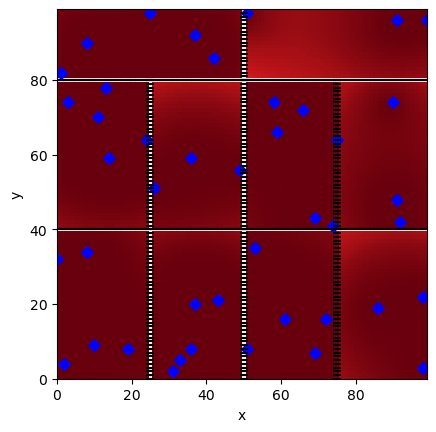

In [86]:
# Run this cell to define the functions
def solution_converter(index, instance_size):
    counter = 0
    for i in range(instance_size):
        for j in range(instance_size):
            if (counter == index):
                return i,j
            else:
                counter+=1

# assumes path_binary is already set 
def visualise_objective_function(x, instance_size, nb_cameras, instance_file):
    params = ['%.16g' % a for a in x]
    cmd = [path_binary_vis,str(instance_size),str(nb_cameras)]+params+[instance_file]
    with open("temp_results.csv",'w') as fd:
        s = subprocess.call(cmd, stdout=fd)
    # Plotting the probability of detection
    data = pd.read_csv("temp_results.csv")
    values = np.array(data["value"])
    values[values < 0.5] = 0
    values = values.reshape(instance_size,instance_size)
    plt.imshow(values,cmap="Reds")
    # Plotting cameras
    cameras_indices = [index for (index, item) in enumerate(list(x)) if item == 1]
    for c in cameras_indices:
        x,y = solution_converter(c, instance_size=instance_size)
        plt.scatter(y,x,c="blue",marker="D")
    # Plotting walls (if any)
    if (instance_file != ""):
        walls = pd.read_csv(instance_file,header=None)
        plt.scatter(walls[1],walls[0],c="black", marker="_")
    plt.xlim(0,instance_size-1)
    plt.xlabel("x")
    plt.ylim(0,instance_size-1)
    plt.ylabel("y")
    plt.show()
    
# Here we just create a random solution for a 100x100 grid with two cameras at random positions
# you can experiment to see what different solutions look like

final_solution = hof[0]

actual_cameras=sum(final_solution)  # need to pass the actual numbers of cameras in the solution, regardless of whether it is valid

# choose an empty grid
#visualise_objective_function(sol, instance_size= 100, nb_cameras=2, instance_file="")

# choose a layout


visualise_objective_function(final_solution, instance_size=instance_size, nb_cameras=actual_cameras, instance_file=myinst)


C:\Users\julka\AppData\Local\Temp\ipykernel_22748\199607758.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  line2 = ax1.plot(gen, fit_min, "b-", label="min Fitness", color="b")


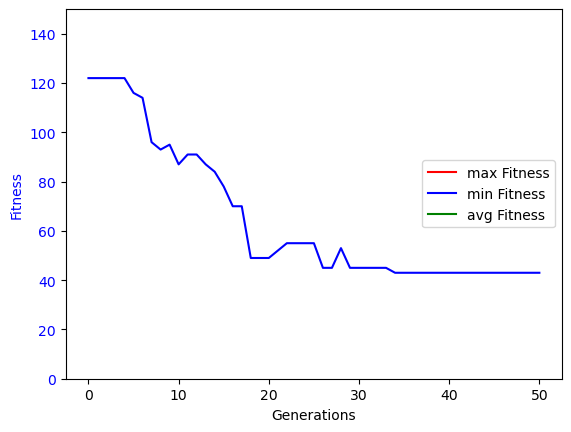

In [98]:
# code for plotting

gen = log.select("gen")
fit_max = log.select("max")
fit_min = log.select("min")
fit_avg = log.select("avg")

fig, ax1 = plt.subplots()
#line1 = ax1.plot(gen, fit_max, "b-", label="max Fitness", color="r")
line2 = ax1.plot(gen, fit_min, "b-", label="min Fitness", color="b")
#line3 = ax1.plot(gen , fit_avg, "b-", label="avg Fitness", color="g")
ax1.set_xlabel("Generations")
ax1.set_ylabel("Fitness", color="b")
for tl in ax1.get_yticklabels():
    tl.set_color("b")
ax1.set_ylim(0,150)
    
lns = line1+line2+line3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="center right")
